<a href="https://colab.research.google.com/github/CSE291A-GEO/anti-geo/blob/simran-dev/Detect_misused_GEO_using_exaggerations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
from nltk import pos_tag, word_tokenize
from typing import List, Dict
import numpy as np
import json
from collections import defaultdict
import random
import matplotlib.pyplot as plt

nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [ ]:
SUPERLATIVE_ADJ_FRACTIONS_KEY = "superlative_adj_fractions"
LEGITIMATE_GEO_INDEX_KEY = "legitimate_geo_index"
MISUSED_GEO_INDEX_KEY = "misused_geo_index"
TRUE_LABELS = {
    LEGITIMATE_GEO_INDEX_KEY: False,
    MISUSED_GEO_INDEX_KEY: True
}

In [ ]:
def load_data(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)

    return dataset

In [ ]:
def is_superlative_adjective(tag: str) -> bool:
    return tag == 'JJS'

def extract_superlative_fraction(text: str) -> float:
    words = word_tokenize(text)
    if not words:
        print("No words found in text. Returning 0.0 fraction.")
        return 0.0
    tags = pos_tag(words)
    superlative_count = sum(1 for word, tag in tags if is_superlative_adjective(tag))
    fraction = superlative_count / len(words)
    # print(f"Extracted superlative fraction: {fraction:.4f} ({superlative_count} superlative adjectives / {len(words)} total words)")
    return fraction

def process_dataset(dataset: List[Dict]) -> List[Dict]:
    results = []

    print(f"Processing dataset with {len(dataset)} entries...")

    for i, entry in enumerate(dataset):
        query = entry.get('query', '')
        sources = entry.get('sources', [])
        misused_geo_index = entry.get('sugg_idx', -1)

        # print(f"\nEntry {i+1}: Query='{query[:50]}...' | sources={len(sources)} | misused_geo_index={misused_geo_index}")

        if not sources or misused_geo_index < 0 or misused_geo_index >= len(sources):
            print("Skipping entry due to invalid sources or misused_geo_index.")
            continue

        legitimate_geo_index = misused_geo_index

        # Pick a different random index to misused_geo_index
        while legitimate_geo_index == misused_geo_index and len(sources) > 1:
            legitimate_geo_index = random.choice(range(len(sources)))

        # print(f"Selected legitimate_geo_index={legitimate_geo_index} different from misused_geo_index={misused_geo_index}")

        sampledSources = {
            LEGITIMATE_GEO_INDEX_KEY: legitimate_geo_index,
            MISUSED_GEO_INDEX_KEY: misused_geo_index
        }

        fractions = {}
        for indexType, index in sampledSources.items():
            cleaned_text = sources[index].get('cleaned_text', '')
            fraction = extract_superlative_fraction(cleaned_text)
            fractions[indexType] = (index, fraction)

        print(f"Entry {i+1}: Fractions = {str(fractions)}")

        results.append({
            'query': query,
            SUPERLATIVE_ADJ_FRACTIONS_KEY: fractions
        })

    print(f"\nProcessed {len(results)} dataset entries.")
    return results

In [ ]:
def scale_fractions(results):
    # Extract all fractions to list
    all_fractions = []
    for res in results:
        fractions = res['superlative_adj_fractions']
        for index_type, (idx, fraction) in fractions.items():
            all_fractions.append(fraction)

    min_frac = min(all_fractions)
    max_frac = max(all_fractions)
    range_frac = max_frac - min_frac if max_frac != min_frac else 1.0

    print(f"\nScaling fractions: min={min_frac}, max={max_frac}")

    # Apply scaling in place
    fractionsForMisusedGEO = []
    fractionsForLegitimateGEO = []
    for res in results:
        fractions = res['superlative_adj_fractions']
        for index_type in fractions:
            idx, old_fraction = fractions[index_type]
            scaled = (old_fraction - min_frac) / range_frac
            fractions[index_type] = (idx, scaled)

            if index_type == MISUSED_GEO_INDEX_KEY:
              fractionsForMisusedGEO.append(scaled)
            else:
              fractionsForLegitimateGEO.append(scaled)


    fractionsForMisusedGEO = np.array(fractionsForMisusedGEO)
    meanFractionForMisusedGEO = np.average(fractionsForMisusedGEO)

    print(f"\nMean fractions for Misused GEO = {meanFractionForMisusedGEO}\n")
    plt.plot(fractionsForMisusedGEO, marker='o')
    plt.title('Fractions for Misused GEO')
    plt.grid(True)
    plt.show()

    fractionsForLegitimateGEO = np.array(fractionsForLegitimateGEO)
    meanFractionForLegitimateGEO = np.average(fractionsForLegitimateGEO)

    print(f"\nMean fractions for Legitimate GEO = {meanFractionForLegitimateGEO}\n")
    plt.plot(fractionsForLegitimateGEO, marker='o')
    plt.title('Fractions for Legitimate GEO')
    plt.grid(True)
    plt.show()

    return results

In [ ]:
def evaluate_labels_and_accuracy(results, dataset):
    total_predictions = 0
    total_correct = 0
    tag_correct_counts = defaultdict(int)
    tag_total_counts = defaultdict(int)
    exaggeratedScores = []

    print("\nCalculating accuracy")
    for idx, (res, data) in enumerate(zip(results, dataset)):
        fractions = res[SUPERLATIVE_ADJ_FRACTIONS_KEY]

        for indexType, (index, fraction) in fractions.items():
          predictions = {
              indexType: (fraction > 0.5)
          }

          if indexType == MISUSED_GEO_INDEX_KEY:
            exaggeratedScores.append(fraction)

        # print(f"Entry {idx+1}: Predictions={predictions}")

        # Count correct labels
        correct = 0
        exaggeratedScores = []
        for indexType, true in TRUE_LABELS.items():
            predicted = predictions.get(indexType, False)
            if predicted == true:
                correct += 1
                # print(f"Correct prediction for entry {idx+1}, label: {indexType}")

        # Fetch tags list for this query
        tags = data.get('tags', [])
        for tag in tags:
          tag_correct_counts[tag] += correct
          tag_total_counts[tag] += len(TRUE_LABELS)

        total_correct += correct
        total_predictions += len(TRUE_LABELS)

    accuracy = total_correct / total_predictions if total_predictions else 0
    print(f"\nOverall label accuracy: {accuracy:.2%}")

    # Calculate accuracy per tag
    tag_accuracy = {}
    for tag, total in tag_total_counts.items():
        correct = tag_correct_counts[tag]
        tag_accuracy[tag] = correct / total if total else 0
        print(f"Tag '{tag}' accuracy: {tag_accuracy[tag]:.2%}")

    return accuracy, tag_accuracy


In [ ]:
dataset = load_data("optimization_dataset.json")

Processing dataset with 100 entries...
Entry 1: Fractions = {'legitimate_geo_index': (4, 0.002512562814070352), 'misused_geo_index': (3, 0.0019267822736030828)}
Entry 2: Fractions = {'legitimate_geo_index': (1, 0.0006430868167202572), 'misused_geo_index': (4, 0.0)}
Entry 3: Fractions = {'legitimate_geo_index': (2, 0.0033715441672285905), 'misused_geo_index': (1, 0.0025364616360177552)}
Entry 4: Fractions = {'legitimate_geo_index': (2, 0.002886002886002886), 'misused_geo_index': (4, 0.0004278990158322636)}
Entry 5: Fractions = {'legitimate_geo_index': (0, 0.0), 'misused_geo_index': (4, 0.0)}
Entry 6: Fractions = {'legitimate_geo_index': (2, 0.0), 'misused_geo_index': (3, 0.000687757909215956)}
Entry 7: Fractions = {'legitimate_geo_index': (2, 0.0), 'misused_geo_index': (1, 0.0029940119760479044)}
Entry 8: Fractions = {'legitimate_geo_index': (2, 0.0018214936247723133), 'misused_geo_index': (4, 0.0005)}
Entry 9: Fractions = {'legitimate_geo_index': (3, 0.0014545454545454545), 'misused_ge

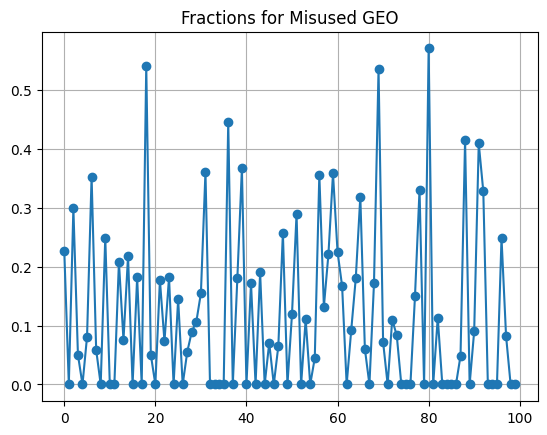


Mean fractions for Legitimate GEO = 0.18178016264339117



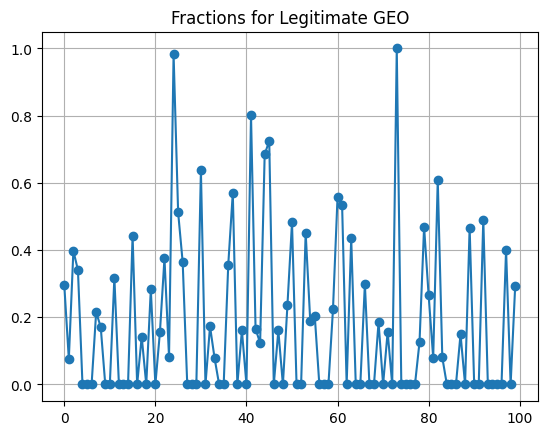


Calculating accuracy

Overall label accuracy: 51.50%
Tag 'informational' accuracy: 51.10%
Tag 'simple' accuracy: 51.81%
Tag 'sports' accuracy: 50.00%
Tag 'non-technical' accuracy: 51.60%
Tag 'command' accuracy: 50.00%
Tag 'research' accuracy: 50.91%
Tag 'fact' accuracy: 51.30%
Tag 'non-sensitive' accuracy: 51.14%
Tag 'arts and entertainment' accuracy: 50.00%
Tag 'question' accuracy: 51.22%
Tag 'history' accuracy: 50.00%
Tag 'historical' accuracy: 53.12%
Tag 'computers and electronics' accuracy: 50.00%
Tag 'technical' accuracy: 50.00%
Tag 'statement' accuracy: 56.25%
Tag 'intermediate' accuracy: 50.00%
Tag 'autos and vehicles' accuracy: 50.00%
Tag 'law and government' accuracy: 50.00%
Tag 'food and drink' accuracy: 50.00%
Tag 'books and literature' accuracy: 50.00%
Tag 'navigational' accuracy: 56.25%
Tag 'games' accuracy: 75.00%
Tag 'health' accuracy: 50.00%
Tag 'latest' accuracy: 50.00%
Tag 'business and industrial' accuracy: 66.67%
Tag 'science' accuracy: 50.00%
Tag 'jobs and educati

In [ ]:
# subsetDatasetSize = len(dataset)
subsetDatasetSize = 100
subsetDataset = dataset[:subsetDatasetSize]

results = process_dataset(subsetDataset)
scaled_results = scale_fractions(results)
accuracy, tag_accuracy = evaluate_labels_and_accuracy(scaled_results, subsetDataset)